In [1]:
import pandas as pd

train = pd.read_csv("../api_example/dataset/census+income+kdd/census/census-income-train.csv")
test = pd.read_csv("../api_example/dataset/census+income+kdd/census/census-income-test.csv")

print(train.shape)
print(test.shape)

(199523, 42)
(99762, 42)


In [2]:
categorical_cols = train.select_dtypes(include=["object", "category"]).columns
numeric_cols = train.select_dtypes(exclude=["object", "category"]).columns.tolist()

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb


X_train = train.drop(columns=["income"])
y_train = train["income"]
X_test = test.drop(columns=["income"])
y_test = test["income"]
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=["object", "category"]).columns.tolist()


for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

model = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model.fit(
    X_train,
    y_train,
    categorical_feature=categorical_cols
)

pred_proba = model.predict_proba(X_test)[:, 1]
auc_cat = roc_auc_score(y_test, pred_proba)
pred = model.predict(X_test)
f1_cat = f1_score(y_test, pred, average='weighted')
f1_cat_macro = f1_score(y_test, pred, average='macro')

print("AUC full:", auc_cat)
print("F1 full:", f1_cat)
print("F1 full:", f1_cat_macro)


X_full = pd.concat([X_train, X_test])

X_full_ohe = pd.get_dummies(
    X_full,
    columns=categorical_cols,
    drop_first=False
)

X_train_ohe = X_full_ohe.iloc[:len(X_train)]
X_test_ohe = X_full_ohe.iloc[len(X_train):]

print(f'\nOHE shape - {X_train_ohe.shape}')


X_train_num = X_train_ohe[numeric_cols]
X_test_num = X_test_ohe[numeric_cols]

# Бинарные признаки (всё остальное)
binary_cols = [col for col in X_train_ohe.columns if col not in numeric_cols]

X_train_categorical_only_ohe = X_train_ohe[binary_cols]
X_test_categorical_only_ohe = X_test_ohe[binary_cols]

model_cat_ohe = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model_cat_ohe.fit(X_train_categorical_only_ohe, y_train)

pred_proba = model_cat_ohe.predict_proba(X_test_categorical_only_ohe)[:, 1]
auc_ohe = roc_auc_score(y_test, pred_proba)
pred = model_cat_ohe.predict(X_test_categorical_only_ohe)
f1_ohe = f1_score(y_test, pred, average='weighted')
f1_ohe_macro = f1_score(y_test, pred, average='macro')

print("AUC with OHE only categorical:", auc_ohe)
print("F1 with OHE only categorical:", f1_ohe)
print("F1 macro with OHE only categorical:", f1_ohe_macro, '\n')

category_cols = [col for col in X_train.columns if col not in numeric_cols]

X_train_categorical_only = X_train[category_cols]
X_test_categorical_only = X_test[category_cols]

model_cat = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model_cat.fit(X_train_categorical_only, y_train)

pred_proba = model_cat.predict_proba(X_test_categorical_only)[:, 1]
auc_ohe = roc_auc_score(y_test, pred_proba)
pred = model_cat.predict(X_test_categorical_only)
f1_ohe = f1_score(y_test, pred, average='weighted')
f1_ohe_macro = f1_score(y_test, pred, average='macro')

print("AUC without OHE only categorical:", auc_ohe)
print("F1 without OHE only categorical:", f1_ohe)
print("F1 macro without OHE only categorical:", f1_ohe_macro, '\n')

sample_idx = np.random.choice(np.arange(len(X_train)), size=20000, replace=False)
X_train_sampled = X_train_categorical_only.iloc[sample_idx]
y_train_sampled = y_train.iloc[sample_idx]

model_cat_sampled = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model_cat_sampled.fit(X_train_sampled, y_train_sampled)

pred_proba = model_cat_sampled.predict_proba(X_test_categorical_only)[:, 1]
auc_ohe = roc_auc_score(y_test, pred_proba)
pred = model_cat_sampled.predict(X_test_categorical_only)
f1_ohe = f1_score(y_test, pred, average='weighted')
f1_ohe_macro = f1_score(y_test, pred, average='macro')

print("AUC only categorical with random 20000 samples:", auc_ohe)
print("F1 only categorical with random 20000 samples:", f1_ohe)
print("F1 macro only categorical with random 20000 samples:", f1_ohe_macro)

AUC full: 0.9553217820448046
F1 full: 0.9530424229243234
F1 full: 0.779158738214784

OHE shape - (199523, 408)
AUC with OHE only categorical: 0.928256299452102
F1 with OHE only categorical: 0.9371772720524862
F1 macro with OHE only categorical: 0.6893428346836602 

AUC without OHE only categorical: 0.9288304829295018
F1 without OHE only categorical: 0.9384782331180369
F1 macro without OHE only categorical: 0.6980052378110123 

AUC only categorical with random 20000 samples: 0.9173785316967626
F1 only categorical with random 20000 samples: 0.9344519880945575
F1 macro only categorical with random 20000 samples: 0.6770163390159862


In [4]:
# получаем label encoding представления, чтобы можно было проще сравнивать категории (в кернелах в итоге смотрится одинаковые ли числа, что ок)
X_full = pd.concat([X_train, X_test])
X_full_le = X_full.copy()

for col in categorical_cols:
    X_full_le[col] = (
        X_full[col]
        .astype("category")
        .cat.add_categories(["__MISSING__"])
        .fillna("__MISSING__")
        .cat.codes
    )
X_train_le = X_full_le.iloc[:len(X_train)]
X_test_le = X_full_le.iloc[len(X_train):]
X_train_num = X_train_le[numeric_cols]
X_test_num = X_test_le[numeric_cols]

X_train_cat_le = X_train_le[categorical_cols]
X_test_cat_le = X_test_le[categorical_cols]

total_ohe_dim = 0
for col in categorical_cols:
    total_ohe_dim += int(X_full_le[col].max() + 1)

In [5]:
X_train_cat_le.shape

(199523, 28)

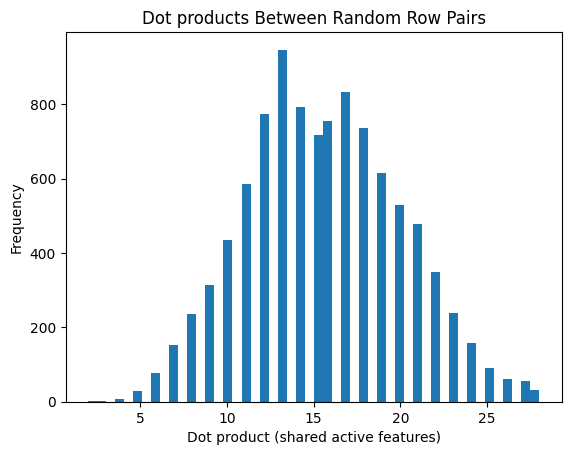

In [6]:
# смотрим скалярные произведения между 10000 рандомными строками в OHE формате (то есть количество совпадений просто)
import numpy as np
import matplotlib.pyplot as plt

X = X_train_categorical_only_ohe[:100000].to_numpy(dtype=np.float32)
n_rows = X.shape[0]
n_pairs = 10000

rng = np.random.default_rng(42)
pairs = rng.choice(n_rows, size=(n_pairs, 2), replace=True)
row_i = X[pairs[:, 0]]
row_j = X[pairs[:, 1]]

dot_products = np.sum(row_i * row_j, axis=1)

plt.hist(dot_products, bins=50)
plt.title("Dot products Between Random Row Pairs")
plt.xlabel("Dot product (shared active features)")
plt.ylabel("Frequency")
plt.show()

In [7]:
from core.sampling_strategies.kernel_sampler import KernelSampler
import torch
from itertools import product
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# для подсчета сколько общих индексов с разными настройками kernel-ов
def pairwise_overlap(tensors):
    n = len(tensors)
    result = torch.zeros((n, n), dtype=torch.float32)

    tensors = [torch.unique(t) for t in tensors]

    for i in range(n):
        for j in range(n):
            a, b = tensors[i], tensors[j]

            inter = torch.isin(a, b).sum()
            union = len(a) + len(b) - inter

            result[i, j] = inter / union * 100

    return result

In [8]:
# смотрим пересечение засемплированных индексов для разных настроек kernel-ов с 1024 якорями
device = "cuda" if torch.cuda.is_available() else "cpu"

x_torch_train = torch.from_numpy(X_train_cat_le.to_numpy()).to(device=device, dtype=torch.long)
x_torch_train_num = torch.from_numpy(X_train_num.to_numpy()).to(device=device, dtype=torch.float32)
x_torch_test = torch.from_numpy(X_test_cat_le.to_numpy()).to(device=device, dtype=torch.long)
x_torch_test_num = torch.from_numpy(X_test_num.to_numpy()).to(device=device, dtype=torch.float32)

idxs = []
for sigma, c in product([0.5, 1, 1.5], [(2, 3), (3, 4)]):
    kernels = [dict(name=f"mC_c{c}", kind="mC", c=mc, weight=1.0) for mc in c]
    kernels.extend([dict(name="mdnf", kind="mdnf", sigma=sigma, weight=1.0), dict(name="match", kind="match", weight=0.5)])
    # это примерно соответствует balanced сэмплеру с преимущественно density score, потому что так лучше получается
    sampler = KernelSampler(sample_size=20000, kernels=kernels, energy_score=0, density_score=0.3, leverage_score=0.7, anchors=1024,
                            random_state=round(sigma*2 + c[0] * 10), w_f=torch.rand((x_torch_train.shape[1],), device=device, dtype=torch.float32))
    idx, A, embeddings_train = sampler.fit_sample(x_torch_train, y=None, sample_mode="topk")
    idxs.append(idx)

pairwise_overlap(idxs)

tensor([[100.0000,  72.5998,  55.1410,  46.8860,  65.8581,  63.2786],
        [ 72.5998, 100.0000,  59.5660,  53.8580,  70.4376,  70.5757],
        [ 55.1410,  59.5660, 100.0000,  63.8874,  67.3010,  65.9476],
        [ 46.8860,  53.8580,  63.8874, 100.0000,  61.0565,  56.1951],
        [ 65.8581,  70.4376,  67.3010,  61.0565, 100.0000,  67.0355],
        [ 63.2786,  70.5757,  65.9476,  56.1951,  67.0355, 100.0000]])

In [9]:
from pytorch_tabnet.tab_model import TabNetClassifier

for anchors in [256, 512, 1024]:
    returned_idxs = []
    for sigma, c in product([0.5, 1, 1.5], [(2, 3), (3, 4)]):
        kernels = [dict(name=f"mC_c{c}", kind="mC", c=mc, weight=1.0) for mc in c]
        kernels.extend(
            [dict(name="mdnf", kind="mdnf", sigma=sigma, weight=1.0), dict(name="match", kind="match", weight=2)]
        )  # + [dict(name="rbf", kind="rbf", weight=1.0)] for numerical features processing
        # это примерно соответствует balanced сэмплеру с преимущественно density score, потому что так лучше получается
        sampler = KernelSampler(sample_size=20000, kernels=kernels, energy_score=0, density_score=0.7, leverage_score=0.3, anchors=anchors,
                                random_state=int(sigma*2 + c[0] * 5), w_f=torch.rand((x_torch_train.shape[1],), device=device, dtype=torch.float32))
        idx, A, embeddings_train = sampler.fit_sample(x_torch_train, x_torch_train_num, y=None)
        embeddings_test = sampler.get_embeddings(x_torch_test, X_num=x_torch_test_num, device=device)
        returned_idxs.append(idx)

        X_train_emb = embeddings_train.cpu().numpy()
        X_test_emb = embeddings_test.cpu().numpy()
        y_train_sample = y_train.iloc[idx.cpu().numpy()]

        scaler = StandardScaler()
        X_train_emb = scaler.fit_transform(X_train_emb)
        X_test_emb = scaler.transform(X_test_emb)

        # с PCA получается хуже
        # pca = PCA(n_components=0.92, svd_solver='full')
        # pca.fit(X_train_emb)
        # X_train_emb = pca.transform(X_train_emb)
        # X_test_emb = pca.transform(X_test_emb)

        print("Train shape:", X_train_emb.shape)
        print("Test shape:", X_test_emb.shape)

        # TabNet ожидает numpy float32
        X_train_emb = np.array(X_train_emb, dtype=np.float32)
        X_test_emb = np.array(X_test_emb, dtype=np.float32)
        y_train_sample = np.array(y_train_sample)
        y_test_np = np.array(y_test)

        # X_train_emb, X_val, y_train_sample, y_val = train_test_split(
        #     X_train_emb,
        #     y_train_sample,
        #     test_size=0.2,
        #     random_state=42,
        #     stratify=y_train_sample
        # )

        model_emb = TabNetClassifier(
            seed=42,
            verbose=0
        )

        model_emb.fit(
            X_train_emb,
            y_train_sample,
            # eval_set=[(X_val, y_val)],
            # eval_name=["val"],
            # eval_metric=["auc"],
            max_epochs=100,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128
        )

        pred_emb = model_emb.predict_proba(X_test_emb)[:, 1]
        auc_emb = roc_auc_score(y_test, pred_emb)
        pred_emb = model_emb.predict(X_test_emb)
        f1_emb = f1_score(y_test, pred_emb, average='weighted')
        f1_emb_macro = f1_score(y_test, pred_emb, average='macro')

        print(f"anchors: {anchors}, sigma: {sigma}, c: {c}")
        print("AUC with emb:", auc_emb)
        print("F1 with emb:", f1_emb)
        print("F1 macro with emb:", f1_emb_macro, '\n')

    idx_overlap = pairwise_overlap(returned_idxs)
    print(idx_overlap)

Train shape: (20000, 1024)
Test shape: (99762, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 0.5, c: (2, 3)
AUC with emb: 0.8886972367065251
F1 with emb: 0.9274321755898854
F1 macro with emb: 0.6393054560395162 

Train shape: (20000, 1024)
Test shape: (99762, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 0.5, c: (3, 4)
AUC with emb: 0.8966396191089256
F1 with emb: 0.9308011032649522
F1 macro with emb: 0.6665012382767108 

Train shape: (20000, 1024)
Test shape: (99762, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1, c: (2, 3)
AUC with emb: 0.8899915678567856
F1 with emb: 0.9322377582170761
F1 macro with emb: 0.679061417827634 

Train shape: (20000, 1024)
Test shape: (99762, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1, c: (3, 4)
AUC with emb: 0.8935861588054513
F1 with emb: 0.9299700109816927
F1 macro with emb: 0.658872446741592 

Train shape: (20000, 1024)
Test shape: (99762, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1.5, c: (2, 3)
AUC with emb: 0.8972631995802186
F1 with emb: 0.9271887915210875
F1 macro with emb: 0.6280137585628125 

Train shape: (20000, 1024)
Test shape: (99762, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1.5, c: (3, 4)
AUC with emb: 0.8873209463486939
F1 with emb: 0.9315287833991888
F1 macro with emb: 0.6680839253257504 

tensor([[100.0000,   5.9210,   6.0136,   5.8145,   5.7753,   5.6943],
        [  5.9210, 100.0000,   6.1036,   6.0249,   6.2022,   5.9575],
        [  6.0136,   6.1036, 100.0000,   6.2389,   6.1768,   6.1374],
        [  5.8145,   6.0249,   6.2389, 100.0000,   6.1881,   6.2050],
        [  5.7753,   6.2022,   6.1768,   6.1881, 100.0000,   5.9799],
        [  5.6943,   5.9575,   6.1374,   6.2050,   5.9799, 100.0000]])
Train shape: (20000, 2048)
Test shape: (99762, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 0.5, c: (2, 3)
AUC with emb: 0.8893849318638658
F1 with emb: 0.9325115852053518
F1 macro with emb: 0.6908495415424704 

Train shape: (20000, 2048)
Test shape: (99762, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 0.5, c: (3, 4)
AUC with emb: 0.8871799496658554
F1 with emb: 0.9298417582220379
F1 macro with emb: 0.654299724447228 

Train shape: (20000, 2048)
Test shape: (99762, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1, c: (2, 3)
AUC with emb: 0.8804848940489245
F1 with emb: 0.9301411663301664
F1 macro with emb: 0.6711690711801854 

Train shape: (20000, 2048)
Test shape: (99762, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1, c: (3, 4)
AUC with emb: 0.8996019712057504
F1 with emb: 0.9312336577613527
F1 macro with emb: 0.6634009975436335 

Train shape: (20000, 2048)
Test shape: (99762, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1.5, c: (2, 3)
AUC with emb: 0.8757631839011559
F1 with emb: 0.9313505517394877
F1 macro with emb: 0.6741547293146185 

Train shape: (20000, 2048)
Test shape: (99762, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1.5, c: (3, 4)
AUC with emb: 0.8901835586350367
F1 with emb: 0.9278863014795857
F1 macro with emb: 0.6362925854857401 

tensor([[100.0000,   6.0333,   6.0305,   5.8649,   5.9210,   5.7613],
        [  6.0333, 100.0000,   6.0389,   6.0192,   6.1881,   5.9126],
        [  6.0305,   6.0389, 100.0000,   6.1712,   6.0895,   5.9911],
        [  5.8649,   6.0192,   6.1712, 100.0000,   6.2050,   6.2050],
        [  5.9210,   6.1881,   6.0895,   6.2050, 100.0000,   6.0108],
        [  5.7613,   5.9126,   5.9911,   6.2050,   6.0108, 100.0000]])
Train shape: (20000, 4096)
Test shape: (99762, 4096)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 0.5, c: (2, 3)
AUC with emb: 0.8977697545754739
F1 with emb: 0.9335359781132126
F1 macro with emb: 0.6882824870007693 

Train shape: (20000, 4096)
Test shape: (99762, 4096)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 0.5, c: (3, 4)
AUC with emb: 0.8807819782532439
F1 with emb: 0.927609335736411
F1 macro with emb: 0.6565115383603526 

Train shape: (20000, 4096)
Test shape: (99762, 4096)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 1, c: (2, 3)
AUC with emb: 0.8853655628730963
F1 with emb: 0.9278258650258552
F1 macro with emb: 0.637144768196857 

Train shape: (20000, 4096)
Test shape: (99762, 4096)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 1, c: (3, 4)
AUC with emb: 0.8865092153984233
F1 with emb: 0.9297929362171792
F1 macro with emb: 0.6603055578939421 

Train shape: (20000, 4096)
Test shape: (99762, 4096)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 1.5, c: (2, 3)
AUC with emb: 0.8940078255659576
F1 with emb: 0.9298135594817464
F1 macro with emb: 0.6505777391513539 

Train shape: (20000, 4096)
Test shape: (99762, 4096)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 1.5, c: (3, 4)
AUC with emb: 0.8838522241023277
F1 with emb: 0.907980623340771
F1 macro with emb: 0.48400211029388945 

tensor([[100.0000,   5.9659,   6.0108,   5.8929,   5.8565,   5.7558],
        [  5.9659, 100.0000,   5.9687,   5.9911,   6.1627,   5.8593],
        [  6.0108,   5.9687, 100.0000,   6.1712,   6.0052,   6.0277],
        [  5.8929,   5.9911,   6.1712, 100.0000,   6.1994,   6.1656],
        [  5.8565,   6.1627,   6.0052,   6.1994, 100.0000,   6.0024],
        [  5.7558,   5.8593,   6.0277,   6.1656,   6.0024, 100.0000]])


Но тем не менее обучение tabnet с обучаемыми эмбедингами внутри модели могут давать результаты чуть похуже чем с эмбедингами от kernel sampler:

In [20]:
from pytorch_tabnet.tab_model import TabNetClassifier

sample_idx = np.random.choice(np.arange(len(X_train_le)), size=20000, replace=False)
X_train_cat_le_sampled = X_train_cat_le.iloc[sample_idx].values
y_train_le_sampled = y_train.iloc[sample_idx]


cat_idxs = list(range(X_train_cat_le_sampled.shape[1]))
cat_dims = [
    int(X_train_cat_le_sampled[:, i].max()) + 1
    for i in range(X_train_cat_le_sampled.shape[1])
]
cat_emb_dim = [min(50, (dim + 1) * 2) for dim in cat_dims]
model_emb = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=cat_emb_dim,
    seed=42,
    verbose=1
)

model_emb.fit(
    X_train_cat_le_sampled.astype(np.int64),
    y_train_le_sampled,
    max_epochs=100,
    patience=15,
    batch_size=1024,
    virtual_batch_size=128
)

pred_emb = model_emb.predict_proba(X_test_cat_le.values)[:, 1]
auc_emb = roc_auc_score(y_test, pred_emb)
pred_emb = model_emb.predict(X_test_cat_le.values)
f1_emb = f1_score(y_test, pred_emb, average='weighted')
f1_emb_macro = f1_score(y_test, pred_emb, average='macro')

print("AUC with emb:", auc_emb)
print("F1 with emb:", f1_emb)
print("F1 macro with emb:", f1_emb_macro, '\n')

/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.25076 |  0:00:00s
epoch 1  | loss: 0.18896 |  0:00:00s
epoch 2  | loss: 0.18011 |  0:00:01s
epoch 3  | loss: 0.17395 |  0:00:01s
epoch 4  | loss: 0.16548 |  0:00:01s
epoch 5  | loss: 0.15687 |  0:00:02s
epoch 6  | loss: 0.15545 |  0:00:02s
epoch 7  | loss: 0.15273 |  0:00:02s
epoch 8  | loss: 0.14837 |  0:00:03s
epoch 9  | loss: 0.14759 |  0:00:03s
epoch 10 | loss: 0.14349 |  0:00:03s
epoch 11 | loss: 0.14407 |  0:00:04s
epoch 12 | loss: 0.14115 |  0:00:04s
epoch 13 | loss: 0.14009 |  0:00:04s
epoch 14 | loss: 0.13758 |  0:00:05s
epoch 15 | loss: 0.13661 |  0:00:05s
epoch 16 | loss: 0.13616 |  0:00:05s
epoch 17 | loss: 0.13542 |  0:00:05s
epoch 18 | loss: 0.13447 |  0:00:06s
epoch 19 | loss: 0.13421 |  0:00:06s
epoch 20 | loss: 0.13278 |  0:00:06s
epoch 21 | loss: 0.13264 |  0:00:07s
epoch 22 | loss: 0.13514 |  0:00:07s
epoch 23 | loss: 0.13118 |  0:00:07s
epoch 24 | loss: 0.12968 |  0:00:08s
epoch 25 | loss: 0.13226 |  0:00:08s
epoch 26 | loss: 0.13074 |  0:00:09s
e

# То же самое для другого датасета (Display Advertising Challenge dataset)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = "../api_example/dataset/criteo/dac/train.txt"

columns = (
    ["label"] +
    [f"I{i}" for i in range(1, 14)] +
    [f"C{i}" for i in range(1, 27)]
)

dataset = pd.read_csv(
    file_path,
    sep="\t",
    names=columns,
    nrows=500_000,
    na_values=[""],
    dtype=str
)

y = dataset["label"]
X = dataset.drop(columns=["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
categorical_cols = [f"C{i}" for i in range(1, 27)]
numeric_cols = [f"I{i}" for i in range(1, 14)]

(460000, 39)
(40000, 39)


In [2]:
# 26 категориальных колонок в анонимизированном виде
for col in categorical_cols:
    print(f'Количество уникальных значений для {col} - {len(X_train[col].unique())}')

n_unique = X_train[categorical_cols].nunique()

cols_to_drop = n_unique[n_unique > 5000].index.tolist()

print("Удаляем:", cols_to_drop)

X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

categorical_cols = [c for c in categorical_cols if c not in cols_to_drop]

Количество уникальных значений для C1 - 1016
Количество уникальных значений для C2 - 527
Количество уникальных значений для C3 - 166109
Количество уникальных значений для C4 - 72252
Количество уникальных значений для C5 - 225
Количество уникальных значений для C6 - 14
Количество уникальных значений для C7 - 10055
Количество уникальных значений для C8 - 473
Количество уникальных значений для C9 - 3
Количество уникальных значений для C10 - 22610
Количество уникальных значений для C11 - 4465
Количество уникальных значений для C12 - 143598
Количество уникальных значений для C13 - 3029
Количество уникальных значений для C14 - 26
Количество уникальных значений для C15 - 7710
Количество уникальных значений для C16 - 113848
Количество уникальных значений для C17 - 10
Количество уникальных значений для C18 - 3465
Количество уникальных значений для C19 - 1703
Количество уникальных значений для C20 - 4
Количество уникальных значений для C21 - 130589
Количество уникальных значений для C22 - 14
Кол

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
import lightgbm as lgb

for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

for col in numeric_cols:
    X_train[col] = X_train[col].astype("float32")
    X_test[col] = X_test[col].astype("float32")

model = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model.fit(
    X_train,
    y_train,
    categorical_feature=categorical_cols
)

pred_proba = model.predict_proba(X_test)[:, 1]
auc_cat = roc_auc_score(y_test, pred_proba)
pred = model.predict(X_test)
f1_cat = f1_score(y_test, pred, average='weighted')
f1_cat_macro = f1_score(y_test, pred, average='macro')

print("AUC full:", auc_cat)
print("F1 full:", f1_cat)
print("F1 macro full:", f1_cat_macro, '\n')

X_train_categorical_only = X_train[categorical_cols]
X_test_categorical_only = X_test[categorical_cols]

model_cat = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model_cat.fit(X_train_categorical_only, y_train)

pred_proba = model_cat.predict_proba(X_test_categorical_only)[:, 1]
auc_ohe = roc_auc_score(y_test, pred_proba)
pred = model_cat.predict(X_test_categorical_only)
f1_ohe = f1_score(y_test, pred, average='weighted')
f1_ohe_macro = f1_score(y_test, pred, average='macro')

print("AUC without OHE only categorical:", auc_ohe)
print("F1 without OHE only categorical:", f1_ohe)
print("F1 macro without OHE only categorical:", f1_ohe_macro, '\n')

sample_idx = np.random.choice(np.arange(len(X_train)), size=50000, replace=False)
X_train_sampled = X_train_categorical_only.iloc[sample_idx]
y_train_sampled = y_train.iloc[sample_idx]

model_cat_sampled = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model_cat_sampled.fit(X_train_sampled, y_train_sampled)

pred_proba = model_cat_sampled.predict_proba(X_test_categorical_only)[:, 1]
auc_ohe = roc_auc_score(y_test, pred_proba)
pred = model_cat_sampled.predict(X_test_categorical_only)
f1_ohe = f1_score(y_test, pred, average='weighted')
f1_ohe_macro = f1_score(y_test, pred, average='macro')

print("AUC only categorical with random 50000 samples:", auc_ohe)
print("F1 only categorical with random 50000 samples:", f1_ohe)
print("F1 macro only categorical with random 50000 samples:", f1_ohe_macro)

AUC full: 0.7781458798715695
F1 full: 0.7541474377238384
F1 macro full: 0.6489139512772484 

AUC without OHE only categorical: 0.7401828276949147
F1 without OHE only categorical: 0.7224131693064061
F1 macro without OHE only categorical: 0.5929148174559515 

AUC only categorical with random 50000 samples: 0.7006781415861242
F1 only categorical with random 50000 samples: 0.716208488784348
F1 macro only categorical with random 50000 samples: 0.5902567205195455


In [4]:
# получаем label encoding представления, чтобы можно было проще сравнивать категории (в кернелах в итоге смотрится одинаковые ли числа, что ок)
X_full = pd.concat([X_train, X_test])
X_full_le = X_full.copy()

for col in categorical_cols:
    X_full_le[col] = (
        X_full[col]
        .astype("category")
        .cat.add_categories(["__MISSING__"])
        .fillna("__MISSING__")
        .cat.codes
    )
X_train_le = X_full_le.iloc[:len(X_train)]
X_test_le = X_full_le.iloc[len(X_train):]
X_train_num = X_train_le[numeric_cols]
X_test_num = X_test_le[numeric_cols]

X_train_cat_le = X_train_le[categorical_cols]
X_test_cat_le = X_test_le[categorical_cols]

total_ohe_dim = 0
for col in categorical_cols:
    total_ohe_dim += int(X_full_le[col].max() + 1)

In [5]:
X_train_cat_le.shape

(460000, 16)


OHE shape - (10000, 15059)


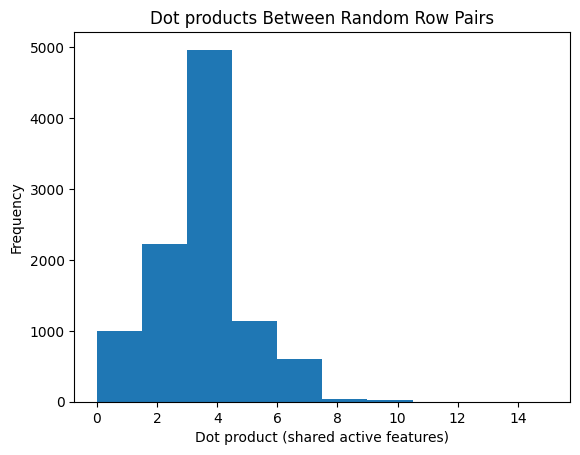

In [7]:
# смотрим скалярные произведения между 10000 рандомными строками в OHE формате (то есть количество совпадений просто)
import numpy as np
import matplotlib.pyplot as plt

X_train_ohe = pd.get_dummies(
    X_train[:10000],
    columns=categorical_cols,
    drop_first=False
)

print(f'\nOHE shape - {X_train_ohe.shape}')

# Бинарные признаки (всё остальное)
binary_cols = [col for col in X_train_ohe.columns if col not in numeric_cols]

X_train_categorical_only_ohe = X_train_ohe[binary_cols].to_numpy()

n_rows = X_train_categorical_only_ohe.shape[0]
n_pairs = 10000

rng = np.random.default_rng(42)
pairs = rng.choice(n_rows, size=(n_pairs, 2), replace=True)

row_i = X_train_categorical_only_ohe[pairs[:, 0]]
row_j = X_train_categorical_only_ohe[pairs[:, 1]]

dot_products = np.sum(row_i * row_j, axis=1)

plt.hist(dot_products, bins=10)
plt.title("Dot products Between Random Row Pairs")
plt.xlabel("Dot product (shared active features)")
plt.ylabel("Frequency")
plt.show()

In [6]:
from core.sampling_strategies.kernel_sampler import KernelSampler
import torch
from itertools import product
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# для подсчета сколько общих индексов с разными настройками kernel-ов
def pairwise_overlap(tensors):
    n = len(tensors)
    result = torch.zeros((n, n), dtype=torch.float32)

    tensors = [torch.unique(t) for t in tensors]

    for i in range(n):
        for j in range(n):
            a, b = tensors[i], tensors[j]

            inter = torch.isin(a, b).sum()
            union = len(a) + len(b) - inter

            result[i, j] = inter / union * 100

    return result


# смотрим пересечение засемплированных индексов для разных настроек kernel-ов с 1024 якорями
device = "cuda" if torch.cuda.is_available() else "cpu"

x_torch_train = torch.from_numpy(X_train_cat_le.to_numpy()).to(device=device, dtype=torch.long)
x_torch_test = torch.from_numpy(X_test_cat_le.to_numpy()).to(device=device, dtype=torch.long)

idxs = []
for sigma, c in product([0.5, 1, 1.5], [(2, 3), (3, 4)]):
    print(sigma, c)
    kernels = [dict(name=f"mC_c{c}", kind="mC", c=mc, weight=1.0) for mc in c]
    kernels.extend(
        [dict(name="mdnf", kind="mdnf", sigma=sigma, weight=1.0), dict(name="match", kind="match", weight=0.5)])
    # это примерно соответствует balanced сэмплеру с преимущественно density score, потому что так лучше получается
    sampler = KernelSampler(sample_size=50000, kernels=kernels, energy_score=0, density_score=0.3, leverage_score=0.7,
                            anchors=1024, random_state=round(sigma * 2 + c[0] * 10))
    idx, A, embeddings_train = sampler.fit_sample(x_torch_train, y=None, sample_mode='topk')
    idxs.append(idx)

pairwise_overlap(idxs)

0.5 (2, 3)
0.5 (3, 4)
1 (2, 3)
1 (3, 4)
1.5 (2, 3)
1.5 (3, 4)


tensor([[100.0000,  74.2889,  75.2357,  74.8191,  77.3081,  71.2036],
        [ 74.2889, 100.0000,  78.3962,  78.6033,  74.4440,  75.3801],
        [ 75.2357,  78.3962, 100.0000,  78.0468,  76.3264,  74.5018],
        [ 74.8191,  78.6033,  78.0468, 100.0000,  75.9294,  73.3373],
        [ 77.3081,  74.4440,  76.3264,  75.9294, 100.0000,  70.2881],
        [ 71.2036,  75.3801,  74.5018,  73.3373,  70.2881, 100.0000]])

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

for anchors in [256, 512, 1024]:
    returned_idxs = []
    for sigma, c in product([0.5, 1, 1.5], [(2, 3), (3, 4)]):
        kernels = [dict(name=f"mC_c{c}", kind="mC", c=mc, weight=1.0) for mc in c]
        kernels.extend(
            [dict(name="mdnf", kind="mdnf", sigma=sigma, weight=1.0), dict(name="match", kind="match", weight=1.0)]
        )  # + [dict(name="rbf", kind="rbf", weight=1.0)] for numerical features processing
        # это примерно соответствует balanced сэмплеру с преимущественно density score, потому что так лучше получается
        sampler = KernelSampler(sample_size=50000, kernels=kernels, energy_score=0, density_score=0.7, leverage_score=0.3, anchors=anchors,
                                random_state=int(sigma*2 + c[0] * 5))
        idx, A, embeddings_train = sampler.fit_sample(x_torch_train, y=None, sample_mode='topk')
        embeddings_test = sampler.get_embeddings(x_torch_test, device=device)
        returned_idxs.append(idx)

        X_train_emb = embeddings_train.cpu().numpy()
        X_test_emb = embeddings_test.cpu().numpy()
        y_train_sample = y_train.iloc[idx.cpu().numpy()]

        scaler = StandardScaler()
        X_train_emb = scaler.fit_transform(X_train_emb)
        X_test_emb = scaler.transform(X_test_emb)

        # с PCA получается хуже
        # pca = PCA(n_components=0.92, svd_solver='full')
        # pca.fit(X_train_emb)
        # X_train_emb = pca.transform(X_train_emb)
        # X_test_emb = pca.transform(X_test_emb)

        print("Train shape:", X_train_emb.shape)
        print("Test shape:", X_test_emb.shape)

        # TabNet ожидает numpy float32
        X_train_emb = np.array(X_train_emb, dtype=np.float32)
        X_test_emb = np.array(X_test_emb, dtype=np.float32)
        y_train_sample = np.array(y_train_sample)
        y_test_np = np.array(y_test)

        # X_train_emb, X_val, y_train_sample, y_val = train_test_split(
        #     X_train_emb,
        #     y_train_sample,
        #     test_size=0.2,
        #     random_state=42,
        #     stratify=y_train_sample
        # )

        model_emb = TabNetClassifier(
            seed=42,
            verbose=0
        )

        model_emb.fit(
            X_train_emb,
            y_train_sample,
            # eval_set=[(X_val, y_val)],
            # eval_name=["val"],
            # eval_metric=["auc"],
            max_epochs=100,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128
        )

        pred_emb = model_emb.predict_proba(X_test_emb)[:, 1]
        auc_emb = roc_auc_score(y_test, pred_emb)
        pred_emb = model_emb.predict(X_test_emb)
        f1_emb = f1_score(y_test, pred_emb, average='weighted')
        f1_emb_macro = f1_score(y_test, pred_emb, average='macro')

        print(f"anchors: {anchors}, sigma: {sigma}, c: {c}")
        print("AUC with emb:", auc_emb)
        print("F1 with emb:", f1_emb)
        print("F1 macro with emb:", f1_emb_macro, '\n')

    idx_overlap = pairwise_overlap(returned_idxs)
    print(idx_overlap)

Train shape: (50000, 1024)
Test shape: (40000, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 0.5, c: (2, 3)
AUC with emb: 0.5912140744465556
F1 with emb: 0.6769787499920619
F1 macro with emb: 0.5279158731307783 

Train shape: (50000, 1024)
Test shape: (40000, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 0.5, c: (3, 4)
AUC with emb: 0.6317424511453102
F1 with emb: 0.6679985527720422
F1 macro with emb: 0.4998805315031767 

Train shape: (50000, 1024)
Test shape: (40000, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1, c: (2, 3)
AUC with emb: 0.6043656121733056
F1 with emb: 0.6641081005142648
F1 macro with emb: 0.5011213907779863 

Train shape: (50000, 1024)
Test shape: (40000, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1, c: (3, 4)
AUC with emb: 0.6281771568623019
F1 with emb: 0.6819964736117082
F1 macro with emb: 0.5308966729884215 

Train shape: (50000, 1024)
Test shape: (40000, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1.5, c: (2, 3)
AUC with emb: 0.6182030809002133
F1 with emb: 0.6781781624293535
F1 macro with emb: 0.5281280126896412 

Train shape: (50000, 1024)
Test shape: (40000, 1024)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1.5, c: (3, 4)
AUC with emb: 0.6284706313336326
F1 with emb: 0.6823420856143553
F1 macro with emb: 0.5414244668050602 

tensor([[100.0000,  67.1291,  74.3466,  70.6368,  77.8442,  74.4318],
        [ 67.1291, 100.0000,  63.6420,  71.3708,  70.5611,  67.5856],
        [ 74.3466,  63.6420, 100.0000,  65.6644,  70.4100,  67.8331],
        [ 70.6368,  71.3708,  65.6644, 100.0000,  75.6821,  68.6312],
        [ 77.8442,  70.5611,  70.4100,  75.6821, 100.0000,  76.4664],
        [ 74.4318,  67.5856,  67.8331,  68.6312,  76.4664, 100.0000]])
Train shape: (50000, 2048)
Test shape: (40000, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 0.5, c: (2, 3)
AUC with emb: 0.6039717242858917
F1 with emb: 0.677280778155394
F1 macro with emb: 0.5268461009100753 

Train shape: (50000, 2048)
Test shape: (40000, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 0.5, c: (3, 4)
AUC with emb: 0.5853668498684189
F1 with emb: 0.6708538272812058
F1 macro with emb: 0.5340458565416871 

Train shape: (50000, 2048)
Test shape: (40000, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1, c: (2, 3)
AUC with emb: 0.61382723221496
F1 with emb: 0.6669079649965463
F1 macro with emb: 0.5000948319165945 

Train shape: (50000, 2048)
Test shape: (40000, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1, c: (3, 4)
AUC with emb: 0.6087729212010736
F1 with emb: 0.6766814225374432
F1 macro with emb: 0.5244009395497589 

Train shape: (50000, 2048)
Test shape: (40000, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1.5, c: (2, 3)
AUC with emb: 0.6136730525712304
F1 with emb: 0.6738951144610518
F1 macro with emb: 0.5290476888481476 

Train shape: (50000, 2048)
Test shape: (40000, 2048)


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
